# Iterative Prisoner's Dilemma


### Description

The [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma) (PD) is a classical game analyzed in game theory, which is widely used to (attempt to) model social/economical interaction. It's a "dilemma" as, if exploited to explain the emergence of altruism in human or in general animal society, it fails badly at a first glance.

The classical situation-representation of the PD is that of two prisoners whose conviction depends on their mutual cooperation. It is easier understood though if illustrated in terms of a trade-off game (closed bag exachange):

*Two people meet and exchange closed bags, with the understanding that one of them contains money, and the other contains a purchase. Either player can choose to honor the deal by putting into his or her bag what he or she agreed, or he or she can defect by handing over an empty bag.*

It is obvious that for both players the winning strategy is to NOT cooperate.

Things changes when the interaction between the two individuals is iterated, in that case a more altruist attitude (strategy) is expected to emerge. The goal of this project is to test this hypothesis.

Mathematically the PD can be expressed with very basic linear algebra. The key component is the **Payoff matrix** $M$, which quantify the reward each player gets depending on whether she cooperated or not (defect):

$$
M = 
\begin{pmatrix} 
R & S \\
T & P 
\end{pmatrix}
$$

with $T,R,S,P$ integers that satisfy the following conditions:

$$
T>R>P>S; \quad 2R > T+S
$$

for example $T=3$, $R=2$, $P=1$ and $S=0$, or  $T=5$, $R=3$, $P=2$, $S=0$. Each player choice (move) can be represented by one of the two axis in ${\rm I\!R}^2$, i.e. $u_C=\begin{pmatrix} 1 \\ 0 \end{pmatrix}$ or $u_D=\begin{pmatrix} 0 \\ 1 \end{pmatrix}$, where the first coordinate stands for *Cooperate* and the second for *Defect*. Being $u_1$ and $u_2$ their rewards $r_1$ and $r_2$ can be computed then as:

$$
r_1 = u_1^T M u_2
\quad
\quad
r_2 = u_2^T M u_1
$$

In an Iterative Prisoner's Dilemma (IPD), two players play prisoner's dilemma more than once in succession and they remember previous actions of their opponent and change their strategy accordingly. The winning strategy is the one which yields to a larger reward at the end of the IPD.

The strategy can be represented as a function which outputs either $u_C$ or $u_D$. Such function can depend on the opponent's history of moves, her on history of moves, on the number of moves played till that moment and so on, but it can only be based on a probability density function. Possible strategies are:

* **Nice guy**: always cooperate (the function's output is always $u_D$)
* **Bad guy**: always defect 
* **Mainly nice**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k<50$
* **Mainly bad**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k>50$
* **tit-for-tat**: start by cooperating, then repeat what the opponent has done in the previous move 

Many more and much more complex strategies can be implemented. The strategy can even change during the IPD.


### Assignments

* Implement a simple IPD between two players implementing two given strategies. Study the evolution along the tournament confronting different strategies; study the overall outcome in the different configurations. 
* Implement a multiple players IPD (MPIPD) where several strategies play against each other in a roud-robin scheme
* Iterate what done in the previous task (repeated MPIPD, rMPIPD)  by increasing the population implementing a given strategy depending on the results that strategy achieved in the previous iteration
* (*difficult*) Implement a rMPIPD where strategies are allowed to mutate. The goal is to simulate the effect of genetic mutations and the effect of natura selection. A parameter (gene) should encode the attidue of an individual to cooperate, such gene can mutate randomly and the corresponding phenotype should compete in the MPIPD such that the best-fitted is determined.  


## Basic elements and 1-on-1 matches

In [7]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt

We start by defining a `Player` class. Each player is assigned two parameters: $k$, which corresponds to the probability of cooperation in each iteration of a game, and $t$, which is related to the “Tit-for-tat” strategy that will be introduced later.

In [8]:
class Player:
    def __init__(self, k, t):
        self.k = k
        self.t = t

    def init_values(self):
        return self.k, self.t

    def name(self):
        # name string for legends in plots, etc.
        return rf"$k = {self.k:.2f}$, $t = {self.t:.2f}$"

    def play(self, hist):
        t = npr.random()
        if t < self.t:
            return True
        elif t < -self.t:
            return False

        return npr.random() < self.k
 
# special child class for tit-for-tat strategies (see later)
class TftPlayer(Player):
    def play(self, hist):
        return hist[-1]

Then a function that implements the basic 1-on-1 game mechanics. The default payoff matrix will be
$$
    M = \begin{pmatrix} 2 & 0 \\ 3 & 1 \end{pmatrix},
$$
corresponding to
$$
    R = 2,\, S = 0,\, T = 3,\, P = 1.
$$
If both players cooperate, they both receive 2 points (**R**eward). If they betray each other, they each receive 1 point (**P**unishment). If one player betrays their cooperative opponent, the betrayer receives 3 points (**T**emptation payoff) while the betrayed player gets 0 (**S**ucker’s payoff).

In [9]:
def game(pl1, pl2, it, payoff=(3, 2, 1, 0)):
    hist1 = [True] # only for the correct initialization of tt_guy
    hist2 = [True] # same
    points = [0, 0]
    
    for i in range(it):
        res1 = pl1.play(hist2)
        res2 = pl2.play(hist1)
        hist1.append(res1)
        hist2.append(res2)
        if res1 and res2:
            points[0] += payoff[1]
            points[1] += payoff[1]
        elif res1 and not res2:
            points[1] += payoff[0]
            points[0] += payoff[3]
        elif not res1 and res2:
            points[1] += payoff[3]
            points[0] += payoff[0]
        else:
            points[0] += payoff[2]
            points[1] += payoff[2]
 
    return points

Then, we define the following basic strategies:
* _nice player_, a player who always cooperates;
* _evil player_, a player who always betrays.

And the intermediate versions:
* _average player_, a player who cooperates half the time;
* _mostly nice player_, a player with a cooperation probability of 0.75;
* _mostly bad player_, a player with a cooperation probability of 0.25.

Also, we’ll implement a basic example of a different kind of strategy, commonly referred to as “tit-for-tat”. A tit-for-tat player starts by cooperating on the first iteration and then copies their opponent’s previous move from that point forward.

In [10]:
nice_pl = Player(1, 0)
evil_pl = Player(0, 0)
avg_pl = Player(0.5, 0)
mnice_pl = Player(0.75, 0)
mevil_pl = Player(0.25, 0)
tt_pl = TftPlayer(0, 1)

Let’s examine some 1-on-1 matchups of these strategies.

The result of a nice versus evil match is easily predicted: Nice will always receive the sucker’s payoff, while Evil will receive a temptation reward in every iteration, resulting in a score of T times the number of iterations to zero in favour of the betrayer.

If the number of iterations is large enough, matchups between mostly nice/evil players are also predictable. For example, in the Evil versus Average matchup, the score ratio will converge to 4 in favour of Evil.
This is because half the time both players will receive $P = 1$ points (reciprocal betrayal), while in the other instances Evil will receive $T=3$ points and Average will receive $S = 0$. So, if $E$ is Evil’s score and $A$ is Average’s,
$$
    \frac{E}{A} \approx \frac{P / 2 + T / 2}{P / 2 + S / 2} = 4.
$$
Indeed:

In [11]:
iters = 1000
evil_v_avg = game(evil_pl, avg_pl, iters)
print(f"Evil v Average:\n {evil_v_avg}")
print(f"Score ratio: {evil_v_avg[0]} / {evil_v_avg[1]} \
= {evil_v_avg[0] / evil_v_avg[1]}")

Evil v Average:
 [1960, 520]
Score ratio: 1960 / 520 = 3.769230769230769


Betrayal usually prevails, as seen in the classic dilemma. The situation becomes more intriguing when a tit-for-tat player is introduced. Let's observe how they fare with the reigning champion.

In [12]:
tt_v_evil = game(tt_pl, evil_pl, iters)
print(f"Tit-for-tat v Evil:\n {tt_v_evil}")

Tit-for-tat v Evil:
 [999, 1002]


Evil wins by three points. The first move is crucial: Tit-for-tat cooperates initially and hence loses three points to Evil. From that point on, they engage in reciprocal betrayal in every turn, resulting in each player earning one point. With our 1000 iterations, the final score becomes 999 to 1002.

Then, what happens to the other players? To get the full picture, we’ll play a small tournament among these six players and look at the averaged scores at the end.

In [13]:
def round_robin(players, iters, num_games):
    N = len(players)
    results = np.zeros((N, N))
    for g in range(num_games):
        for i in range(N):
            # start from i to allow players to compete against themselves
            for j in range(i, N):
                score = game(players[i], players[j], iters)
                # results[i, j] is the sum of all points made
                # by player i when playing j
                results[i, j] += score[0]
                if i == j:
                    continue # avoid double counting
                results[j, i] += score[1]

    # return average points per iteration
    return results / (num_games * iters)

players = [nice_pl, evil_pl, avg_pl, mnice_pl, mevil_pl, tt_pl]
player_names = ["Nice", "Evil", "Average",
                "Mostly Nice", "Mostly Evil", "Tit-for-tat"]

tournament = round_robin(players, 1000, 100)
tournament = pd.DataFrame(tournament,
                          index=player_names,
                          columns=player_names)

tournament

,Nice,Evil,Average,Mostly Nice,Mostly Evil,Tit-for-tat
Nice,2.00000,0.00000,1.00504,1.49842,0.50206,2.00000
Evil,3.00000,1.00000,1.99138,2.49528,1.50496,1.00200
Average,2.49748,0.50431,1.50735,1.99462,0.99846,1.50113
Mostly Nice,2.25079,0.25236,1.25647,1.75226,0.75154,1.75217
Mostly Evil,2.74897,0.74752,1.75314,2.24863,1.24567,1.24957
Tit-for-tat,2.00000,0.99900,1.49981,1.75139,1.24738,2.00000


The entries in the tournament matrix indicate the average score achieved by the player associated with the corresponding row, across all rounds, against the player represented by the column.

Thus, by taking the average along the rows, we can determine which
player performs the best, on average.

In [14]:
standings = tournament.mean(axis=1).sort_values(ascending=False)
standings

Evil           1.832270
Mostly Evil    1.665583
Tit-for-tat    1.582930
Average        1.500558
Mostly Nice    1.335932
Nice           1.167587
dtype: float64

The evil players win, once again!

However, if we look the average score obtained by each player *against themselves*, we get this:

In [15]:
standings_self = pd.Series(np.diag(tournament),
                           index=player_names).sort_values(ascending=False)
standings_self

Nice           2.00000
Tit-for-tat    2.00000
Mostly Nice    1.75226
Average        1.50735
Mostly Evil    1.24567
Evil           1.00000
dtype: float64

So, Evil players do well against other types of players, but their
individualistic strategy leads to suboptimal outcomes for the population
as a whole. A completely Evil population will result in the least favourable
distribution of rewards.

On the other end of the spectrum are Nice and Tit-for-tat players.
Out of these two, as we’ve seen above, Tit-for-tat has a better performance
across the board. If we were to look at it from a “Survival of the Fittest”
perspective, we’d expect Tit-for-tat – or some variant of it – to
become the dominant strategy. This is what we’ll investigate in the next
section.

## Battle Royal

In this section we’ll implement an “evolutionary” round-robin tournament:
we’ll keep a fixed total population of players throughout the tournament,
but the number of players in each class will change proportionally to the 
scores in the previous round. The following function `init_classed` sets
up the initial population of players. We’ll start with a uniform 
distribution of the six strategies we discussed in the previous section.

In [16]:
def init_classed(num_players):
    return np.array([Player(1, 0), Player(0.75, 0), Player(0.5, 0), 
                     Player(0.25, 0), Player(0, 0), TftPlayer(0, 1)]
                    * (num_players // 6)
                    # fill remaining spots with Average players
                    + [Player(0.5, 0)] * (num_players % 6))

The next function, `repeated`, performs a run of a given number of cycles 
and stops it if the scores remain unchanged for 20 consecutive cycles, with
a tolerance of 0.001%. The function `select` is used to sort the results
and adjust the distribution of the population according to the following 
rule:
$$
    C_i^{(n + 1)} = C_i^{(n)} \biggl(1 + \frac{S_i^{(n)} - \mu_{\vphantom{i}}^{(n)}}{\mu^{(n)}}\biggr),
$$
where $C_i^{(n)}$ is the number of players in the class (strategy) $i$ at the $n$-th
cycle, $S_i^{(n)}$ the score of the $i$-th class, and
$$
    \mu^{(n)} = \frac{1}{N_\mathrm{p}} \sum_{i = 1}^{N_\mathrm{c}}
    C_i^{(n)} S_i^{(n)}
$$
with $N_\mathrm{c}$ the number of classes and $N_\mathrm{p}$ the total number of players. Here is a simple proof that the total population doesn’t change using this update rule:
$$
    \sum_{i=1}^{N_\mathrm{c}} C_{i}^{(n + 1)} = \sum_{i = 1}^{N_\mathrm{c}} {}\Biggl[C_i^{(n)} + 
    \frac{C_i^{(n)}}{\mu^{(n)}} \Biggl(S_i^{(n)} - \frac{1}{N_\mathrm{p}} \sum_{j = 1}^{N_\mathrm{c}} C_j^{(n)} S_j^{(n)} \Biggr)\Biggr],
$$
and since $C_i^{(n)} = N_\mathrm{p}$,
$$
    \sum_{i = 1}^{N_\mathrm{c}} C_{i}^{(n + 1)} 
    = N_\mathrm{p} + 
        \frac{1}{\mu^{(n)}} \sum_{i=1}^{N_\mathrm{c}} C_i^{(n)} S_i^{(n)} 
        - \frac{N_\mathrm{p}}{\mu^{(n)}} \sum_{j = 1}^{N_\mathrm{c}} \frac{C_{j}^{(n)} S_j^{(n)}}{N_\mathrm{p}} = N_\mathrm{p}.
$$
So, the strategies with higher scores will reproduce more, while the population with below-average performance will decrease as the tournament progresses.

We’ll also redefine the tournament function to perform the calculations in parallel, to better handle a large number of players.

In [17]:
from multiprocessing import Pool 

def round_robin(players, iters):
    N = len(players)

    results = [[None for i in range(N)] for j in range(N)]
    scores = [0 for i in range(N)]

    with Pool() as p:
        for i in range(N):
            for j in range(i + 1, N):
                res = p.apply_async(game, (players[i], players[j], iters))
                results[i][j] = res
        
        for i in range(N):
            for j in range(i + 1, N):
                res = results[i][j].get()
                scores[i] += res[0]
                scores[j] += res[1]
    
    return scores

In [18]:
def select(players, scores, notquite=False):
    num_players = len(players)
    
    #types = {(p.name(), p.init_values()) for p in players}
    types = []
    for p in players:
        player_type = (p.__class__, p.init_values())
        for t in types:
            if t == player_type:
                break
        else:
            types.append(player_type)

    sc_by_type = []
    num_by_type = []

    for idx_t, t in enumerate(types):
        t_score = []
        for idx_p, p in enumerate(players):
            if t == (p.__class__, p.init_values()):
                t_score.append(scores[idx_p])
 
        sc_by_type.append(np.mean(t_score))
        num_by_type.append(len(t_score))

    if notquite:
        return types, sc_by_type, num_by_type

    glob = sorted([(types[i], sc_by_type[i], num_by_type[i])
                   for i in range(len(types))],
                  key=lambda x: x[1], reverse=True)

    types = [g[0] for g in glob]
    sc_by_type = np.array([g[1] for g in glob])
    num_by_type = np.array([g[2] for g in glob])

    mu = np.sum(num_by_type * sc_by_type) / num_players
    new_nums = (num_by_type
                + num_by_type * (sc_by_type - mu) / mu).astype(int)
        
    new_players = []
    for idx_t in range(len(types)):
        for n in range(new_nums[idx_t]):
            new_players.append(types[idx_t][0](*types[idx_t][1]))
    while len(new_players) < num_players:
        new_players.append(types[0][0](*types[0][1]))

    return new_players

In [19]:
def repeated(num_players, iters, cycles, classed=True):
    if classed:
        players = init_classed(num_players)
    else:
        players = init(num_players)

    scores = round_robin(players, iters)
    results = [(players, scores)]

    stop_counter = 0
    for i in range(cycles - 1):
        if classed:
            players = select(players, scores)
        else:
            players = evolve(players, scores)

        scores = round_robin(players, iters)
        results.append((players, scores))

        if (np.allclose(scores, results[i][1],
                        atol=0.0001 * max(scores))):
            stop_counter += 1
        else:
            stop_counter = 0
        
        if stop_counter == 20:
            break

    return results

Then, the function `stats` computes the mean and standard deviation of the scores for each strategy over the last 20 cycles, where a stable solution should have been reached. Additionally, it generates two plots to display the trend of both the count and score of each strategy.

In [110]:
from seaborn import color_palette

def stats(results):
    scores = []
    counts = []
    strats, scs, nums = select(*results[0], True)
    names = [s[0](*s[1]).name() for s in strats]

    scores.append(scs)
    counts.append(nums)

    for res in results[1:]:
        strats, scs, nums = select(*res, True)
        new_names = [s[0](*s[1]).name() for s in strats]

        sc_ord = []
        num_ord = []
        for i in range(len(names)):
            for j in range(len(new_names)):
                if new_names[j] == names[i]:
                    sc_ord.append(scs[j])
                    num_ord.append(nums[j])
                    break
            else:
                sc_ord.append(0)
                num_ord.append(0)

        scores.append(sc_ord)
        counts.append(num_ord)
    
    # sort names by k value, then t
    def sort_names(name):
        t, k = name.split(", ")
        t_value = float(t.split(" = ")[1].strip("$"))
        k_value = float(k.split(" = ")[1].strip("$"))
        return (k_value, t_value)
    
    sort_idx = [names.index(n) for n in sorted(names, key=sort_names)]
    names = np.asarray(names)[sort_idx]
    scores = np.asarray(scores).T[sort_idx]
    counts = np.asarray(counts).T[sort_idx]

    means = []
    dev = []

    num_rounds = len(results)
    
    colors = color_palette("coolwarm", len(names) - 1)[::-1] + ["#3E8E41"]
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    for n in range(len(names)):
        means.append(np.mean(scores[n][-20:]))
        dev.append(np.std(scores[n][-20:]))

        # stop plotting when count is 0
        mask = (counts[n] > 0)
        rounds = np.arange(0, num_rounds)
        ax[0].plot(rounds[mask], scores[n][mask],
                   c=colors[n], label=names[n])
        ax[1].plot(rounds, counts[n],
                   c=colors[n], label=names[n])

    for i in (0, 1):
        ax[i].set_ylim(0)
        ax[i].set_xlim((0, num_rounds - 1))
        ax[i].set_xlabel("Round number")
    ax[0].set_ylabel("Average score per round")
    ax[1].set_ylabel("Number of players")

    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="right")

    return strats, means, dev

In [21]:
N = 120
it = 100
cyc = 100

hist = repeated(N, it, cyc)

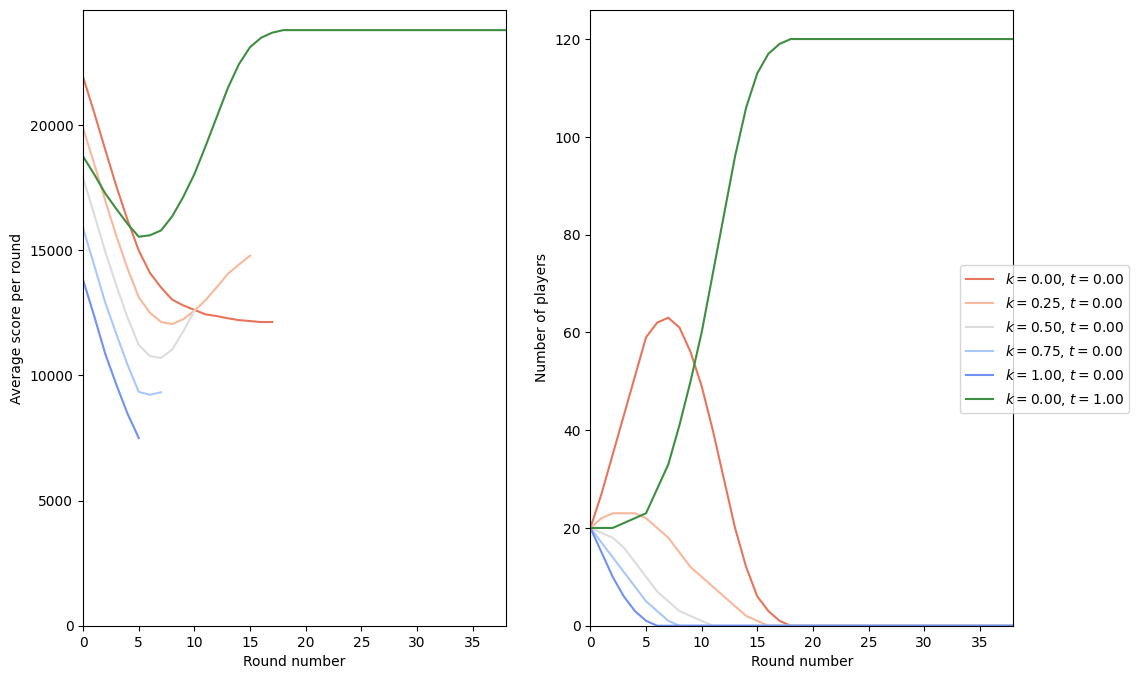

In [111]:
strategies, means, stdevs = stats(hist)

It’s interesting to note that initially, the average score of all strategies decreases. This is because the Evil players ($k = 0$, $t = 0$) have the highest score in the first five rounds, leading to an increase in their population, which decreases the average score of all other strategies. The only strategy that can compete is, indeed, Tit-for-tat, as it earns more points than the constant betrayers, thanks to their cooperative behaviour with players of the same species and a defecting behaviour towards Evils.

Here’s another important example with only 5 Tit-for-tats grouped with 95 Evil players.

In [113]:
def init_classed(N):
    return np.array([Player(0, 0)] * (N - 5) + [Player(0, 1)] * 5)

N = 100
it = 100
cyc = 100
hist = repeated(N, it, cyc)

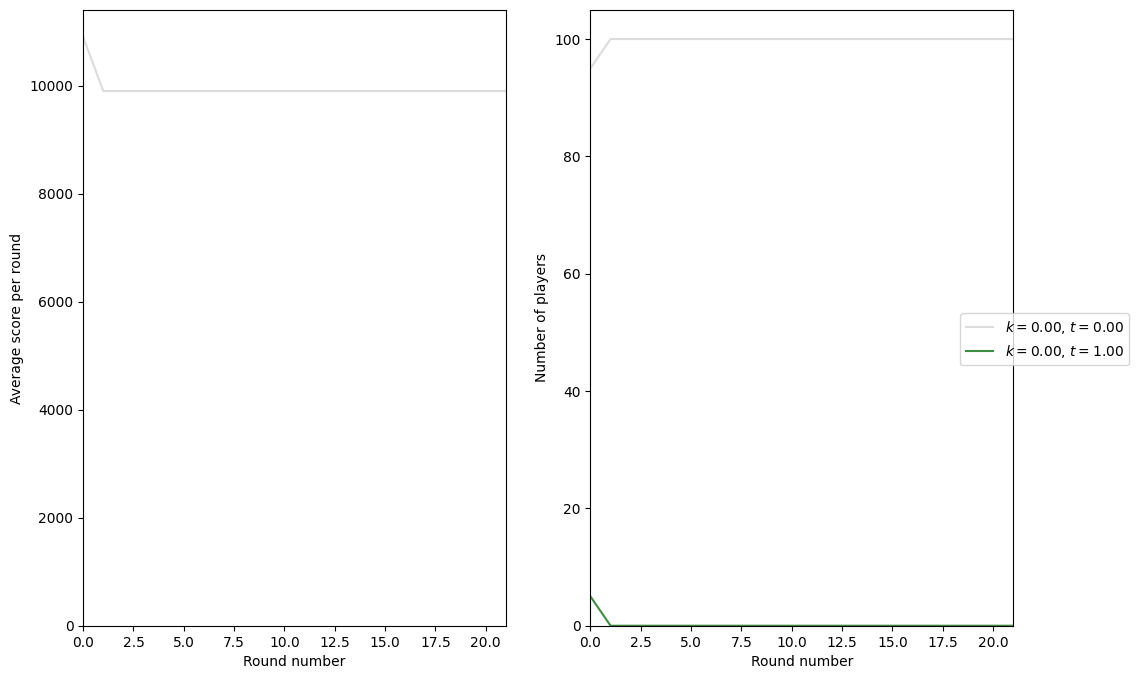

In [114]:
strategies, means, stdevs = stats(hist)